In [1]:
import json
import numpy as np
import os
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt

%matplotlib inline

# pose problem
* historical precedence
    * 'collection of rules which provide tools for running a variety of social, asymmetric, scenerio-based games'
    * war game background -> simulationist tendencies
    * strong tradition of procedural generation
* srd-ogl data ->
    * semi-structured text
    * particular target, which is a heuristic
    * published a heuristic, but did not release (hence, proprietary)



# work in progress - report
* problems w/ data set
    * entirely human generated; labels may not be deterministic (how should we deal with this?)
        * cr should be distributional, use 'ordinal classification'
    * target values are part of a heuristic model
* exploratory analysis
    * useful for identifying features with strong correlations

# Dungeons & Dragons & Data

* Dungeons & Dragons is a scenario-based, asymmetric, social game.
* First published role-playing game (Gygax and Arneson, 1974).

## Why might this be interesting?

* Rich history of procedural generation.

* Open Gaming License: [SRD-OGL 5.1](http://media.wizards.com/2016/downloads/DND/SRD-OGL_V5.1.pdf)

* Working with these datasets is simplified due to some prior work: 
    * Redditor [droiddruid](https://www.reddit.com/user/droiddruid), who published a list of [monsters](https://dl.dropboxusercontent.com/s/iwz112i0bxp2n4a/5e-SRD-Monsters.json).
    * GitHub user [vorpalhex](https://github.com/vorpalhex), who extracted a list of [spells](https://github.com/vorpalhex/srd_spells).

In [2]:
def load_data(filepath, url):
    # Load data from either local file or remote copy. If the local file does not exist,
    # create a local copy of the data.
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            data = json.load(f)
    else:
        response = requests.get(url)
        data = json.loads(response.text)
        with open(filepath, 'w') as f:
            json.dump(data, f)
    return data

def load_monsters():
    # Load monster data.
    filepath = 'data/5e-SRD-Monsters.json'
    url = 'https://dl.dropboxusercontent.com/s/iwz112i0bxp2n4a/5e-SRD-Monsters.json'
    data = load_data(filepath, url)
    monsters = data[:-1]
    ogl = data[-1]
    return monsters, ogl

def load_spells():
    # Load spell data.
    filepath = 'data/5e-SRD-spells.json'
    url = 'https://raw.githubusercontent.com/vorpalhex/srd_spells/master/spells.json'
    return load_data(filepath, url)

monsters, ogl = load_monsters()
spells = load_spells()

## Example stat block

In [3]:
%%html
<table><tr><td><p><em>Kobold</em><div class="stat_block"><p class="type">Small humanoid (kobold), lawful evil</p><hr /><p><strong>Armor Class</strong> 12</p><p><strong>Hit Points</strong> 5 (2d6 − 2)</p><p><strong>Speed</strong> 30 ft.</p><hr /><table><thead><tr><th>STR</th><th>DEX</th><th>CON</th><th>INT</th><th>WIS</th><th>CHA</th></tr></thead><tbody><tr><td>7 (−2)</td><td>15 (+2)</td><td>9 (−1)</td><td>8 (−1)</td><td>7 (−2)</td><td>8 (−1)</td></tr></tbody></table><hr /><p><strong>Senses</strong> darkvision 60 ft., passive Perception 8</p></td><td><p><strong>Languages</strong> Common, Draconic</p><p><strong>Challenge</strong> 1/8 (25 XP)</p><hr /><p class="special_trait"><em><strong>Sunlight Sensitivity.</strong></em> While in sunlight, the kobold has disadvantage on attack rolls, as well as on Wisdom (Perception) checks that rely on sight.</p><p class="special_trait"><em><strong>Pack Tactics.</strong></em> The kobold has advantage on an attack roll against a creature if at least one of the kobold’s allies is within 5 feet of the creature and the ally isn’t incapacitated.</p><p><strong>Actions</strong><p><em><strong>Dagger.</strong></em> <em>Melee Weapon Attack:</em> +4 to hit, reach 5 ft., one target.<br /><em>Hit:</em> 4 (1d4 + 2) piercing damage.</p><p><em><strong>Sling.</strong></em> <em>Ranged Weapon Attack:</em> +4 to hit, range 30/120 ft., one target.<br /><em>Hit:</em> 4 (1d4 + 2) bludgeoning damage.</p><p class="lore">Kobolds are craven reptilian humanoids that commonly infest dungeons. They make up for their physical ineptitude with a cleverness for trap making.</p></div></dd></td></tr></table>

# Project goals
1. Given a stat block, can we predict the challenge rating?
2. Given a target challenge rating, can we generate a stat block?

## Exploratory analysis

Before attempting to answer questions 1) and 2), it's helpful to understand some of the underlying relationships in the data.

In [4]:
# Load tidied dataframes

spells_df = pd.read_pickle('data/spells_df')
monster_df = pd.read_pickle('data/monster_df')
actions_df = pd.read_pickle('data/actions_df')
spellbook_df = pd.read_pickle('data/spellbook_df')
innate_spellbook_df = pd.read_pickle('data/innate_spellbook_df')
special_abilities_df = pd.read_pickle('data/special_abilities_df')

condition_immunities_df = pd.read_pickle('data/condition_immunities_df')
damage_immunities_df = pd.read_pickle('data/damage_immunities_df')
damage_resistances_df = pd.read_pickle('data/damage_resistances_df')
damage_vulnerabilities_df = pd.read_pickle('data/damage_vulnerabilities_df')

In [5]:
dfs = [spells_df,
       monster_df,
       actions_df,
       spellbook_df,
       innate_spellbook_df,
       special_abilities_df,
       condition_immunities_df,
       damage_immunities_df,
       damage_resistances_df,
       damage_vulnerabilities_df]
keys = ["spells_df",
        "monster_df",
        "actions_df",
        "spellbook_df",
        "innate_spellbook_df",
        "special_abilities_df",
        "condition_immunities_df",
        "damage_immunities_df",
        "damage_resistances_df",
        "damage_vulnerabilities_df"]
dataframes = {x: y for x, y in zip(keys, dfs)}

In [6]:
from plotnine import (aes, coord_flip, geom_boxplot, geom_abline, geom_histogram,
                      geom_point, geom_text, geom_tile, ggplot,
                      element_text, facet_grid, stat_bin,
                      theme_bw, theme_seaborn, theme)

/Users/jason/Code/cr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [7]:
dataframes.keys()

dict_keys(['spells_df', 'monster_df', 'actions_df', 'spellbook_df', 'innate_spellbook_df', 'special_abilities_df', 'condition_immunities_df', 'damage_immunities_df', 'damage_resistances_df', 'damage_vulnerabilities_df'])

In [8]:
df = pd.DataFrame.copy(monster_df)
df.challenge_rating = df.challenge_rating.astype('category')

# I should automate this bit
# due to a matplotlib bug, plotnine doesn't handle categoricals with one datapoint gracefully
counts = df.challenge_rating.groupby(df.challenge_rating).count().rename('count')
singletons = [x for x in counts.index[counts == 1]]
a = df[df.challenge_rating.apply(lambda x: x not in singletons)]
b = df[df.challenge_rating.apply(lambda x: x in singletons)]

Let's focus on the `monster_df`.

In [9]:
subset = ['challenge_rating', 'armor_class', 'hit_points', 'strength',
       'dexterity', 'constitution', 'intelligence', 'wisdom', 'charisma']

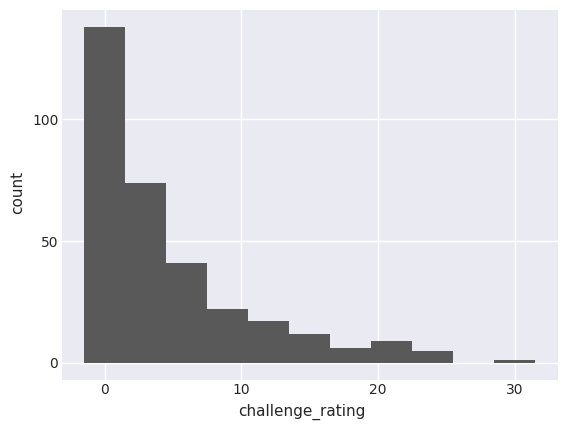

<ggplot: (279944603)>

In [10]:
ggplot(monster_df, aes(x='challenge_rating')) \
    + geom_histogram(stat=stat_bin(binwidth=3)) + theme_seaborn()

In [11]:
monster_df[subset].corr()['challenge_rating']

challenge_rating    1.000000
armor_class         0.759011
hit_points          0.941061
strength            0.722490
dexterity          -0.023984
constitution        0.859834
intelligence        0.642374
wisdom              0.549235
charisma            0.692209
Name: challenge_rating, dtype: float64

If we consider the correlation matrix, `challenge_rating` best correlates with `hit_points`, `constitution`, and `armor_class`.

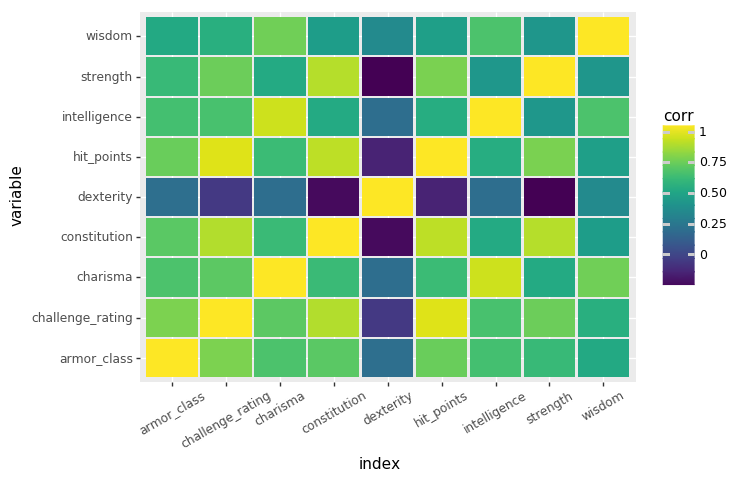

<ggplot: (-9223372036574763099)>

In [12]:
ggplot(pd.melt(monster_df[subset].corr().reset_index(),
               id_vars=['index'],
               value_name='corr'),
       aes('index', 'variable', fill='corr')) \
    + geom_tile(aes(width=.95, height=.95)) \
    + theme(axis_text_x=element_text(angle=30))

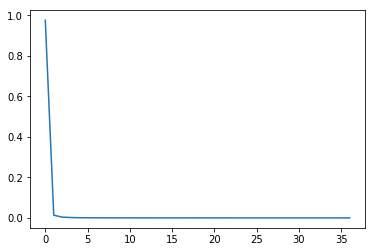

In [13]:
from sklearn.decomposition import PCA
pca = PCA()

X = monster_df.select_dtypes(include=['float64', 'int64'])
pca.fit(X)
plt.plot(pca.explained_variance_ratio_);

We can futher explore the relationships between factors in `monster_df`.

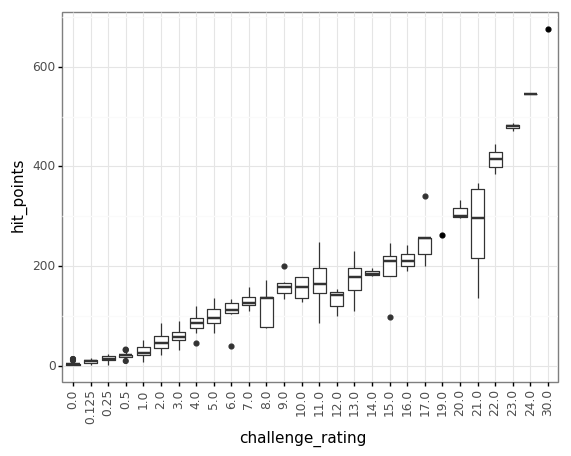

<ggplot: (-9223372036574081287)>

In [14]:
ggplot(a, aes(x='challenge_rating', y='hit_points')) + geom_boxplot() \
    + geom_point(b, aes(x='challenge_rating', y='hit_points')) + theme_bw() \
    + theme(axis_text_x=element_text(angle=90))

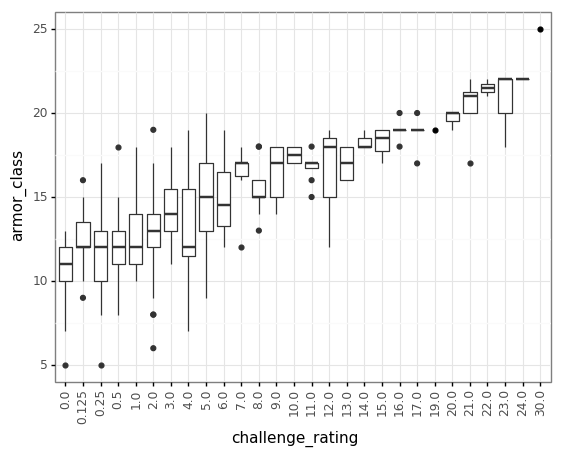

<ggplot: (281419079)>

In [15]:
ggplot(a, aes(x='challenge_rating', y='armor_class')) + geom_boxplot() \
    + geom_point(b, aes(x='challenge_rating', y='armor_class')) + theme_bw() \
    + theme(axis_text_x=element_text(angle=90))

We can also examine the relation with regards to certain categorical variables.

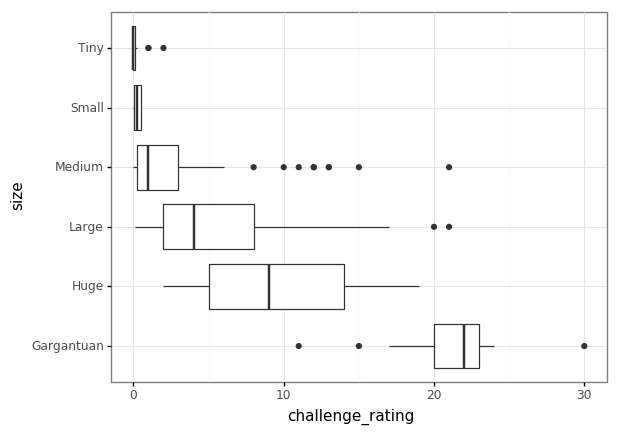

<ggplot: (-9223372036574691573)>

In [16]:
ggplot(monster_df, aes(x='size', y='challenge_rating')) + geom_boxplot() + theme_bw() + coord_flip()

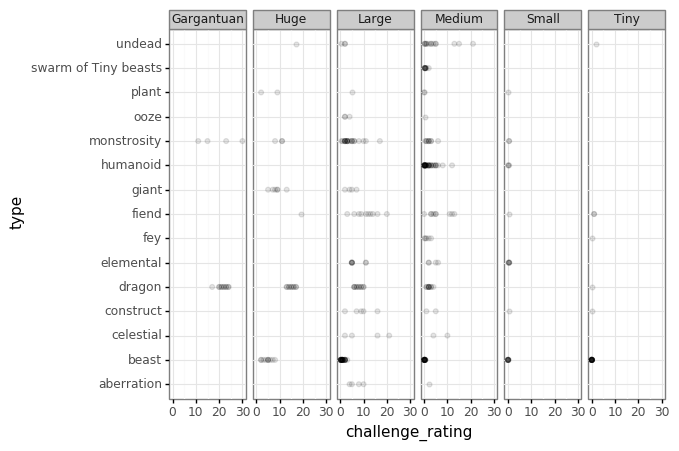

<ggplot: (-9223372036574769976)>

In [17]:
ggplot(monster_df, aes(x='type', y='challenge_rating')) + geom_point(alpha=0.1) \
    + theme_bw() + coord_flip() + facet_grid('. ~ size')

### Fitting a simple linear model

In [18]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
y = monster_df.challenge_rating
X = monster_df[['hit_points', 'armor_class']]
lr.fit(X, y)
print('coefficent of determination: {:.2f}'.format(lr.score(X, y)))

coefficent of determination: 0.90


/Users/jason/Code/cr/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


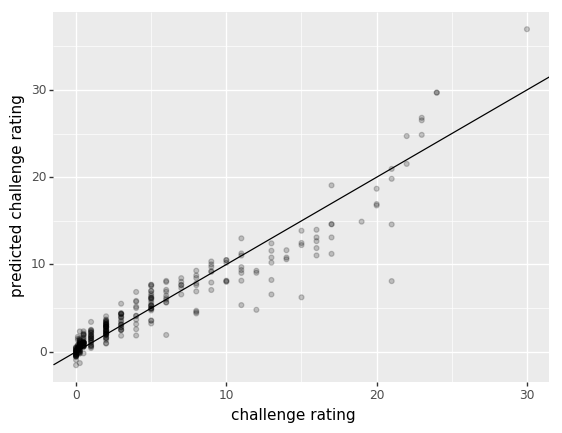

<ggplot: (-9223372036572975300)>

In [19]:
pred = pd.DataFrame({'challenge rating': y,
                     'predicted challenge rating': lr.predict(X)})
ggplot(pred, aes(x='challenge rating', y='predicted challenge rating')) \
    + geom_point(alpha=0.2) + geom_abline(intercept = 0, slope = 1)

In [20]:
# and if we consider all numerical factors?

y = monster_df.challenge_rating
X = monster_df.select_dtypes(include=['float64', 'int64']).copy()
X = X.drop('challenge_rating', axis=1)

lr.fit(X, y)
print('coefficent of determination: {:.2f}'.format(lr.score(X, y)))

coefficent of determination: 0.95


# Next steps
Recall the project goals:
1. Given a stat block, can we predict the challenge rating?
2. Given a target challenge rating, can we generate a stat block?

Is problem 1. a regression or a classification problem?

*My answer:* It has shared similarities with both; it's an ordinal regression or ranked learning problem.

# Building models
* Ordinal classification problem
* initial models
    * goal is to provide simple, explanatory models (bayesian priors?)
* feature extraction
    * use initial models to identify which examples poorly fit, clustering to prioritize feature extraction
* other methods
    * rnns - with a tigher bottleneck!
    * sentiment analysis
    * pre-trained network + embedding of corpus specific words
* deep-dreaming
    * application to perturbative generation



# Feature engineering

In [21]:
pred['delta'] = pred['challenge rating'] - pred['predicted challenge rating']
mean, std_dev = pred.delta.mean(), pred.delta.std()

mask = (pred.delta > mean + 1.7 * std_dev) | (pred.delta < mean - 1.7 * std_dev)
pred[mask].sort_values('delta', ascending=False).head()

,challenge rating,predicted challenge rating,delta
name,,,
Lich,21.0,8.094490,12.905510
Mummy Lord,15.0,6.239372,8.760628
Archmage,12.0,4.803713,7.196287
Rakshasa,13.0,6.567358,6.432642
Solar,21.0,14.593570,6.406430


In [22]:
# add actions
df = actions_df.reset_index().set_index('name')
df.damage_dice.fillna('', inplace=True)
df.damage_bonus.fillna(0, inplace=True)
df.desc = df.action + ': ' + df.desc

def max_damage(x):
    s = 0
    if x:
        for y in x.split('+'):
            z, w = y.strip().split('d')
            s += int(z) * int(w)
    return float(s)

df['max_damage'] = df.damage_dice.apply(max_damage) + df.damage_bonus
df.drop(['damage_dice', 'damage_bonus', 'action'], axis=1, inplace=True)
best_action_df = df.copy()


df = pd.merge(monster_df[subset],
              best_action_df.groupby('name').max()[['attack_bonus', 'max_damage']],
              how='outer',
              left_index=True,
              right_index=True)

In [23]:
# add spellbook
s_df = spellbook_df.select_dtypes(include=['float64', 'int64'])

def max_level_and_slots(x):
    n = len(x.columns)
    level_and_slots = [(l - 3, s) for l, s in enumerate(x.iloc[0]) if s > 0 and l > 3]
    l, x = max(level_and_slots)
    return pd.DataFrame({'max_spell_level': [l], 'num_slots': [x]})
    
s_df = s_df.groupby('name').apply(max_level_and_slots).reset_index()
s_df = s_df.drop(['level_1'], axis=1).set_index('name')

df = pd.merge(df, s_df, how='outer', left_index=True, right_index=True).fillna(0)

By adding some extra engineered features, we can improve our model a bit.

In [24]:
y = df['challenge_rating']
X = df.drop('challenge_rating', axis=1)
X.fillna(0, inplace=True)
lr.fit(X, y)
lr.score(X, y)

0.9421878279972502

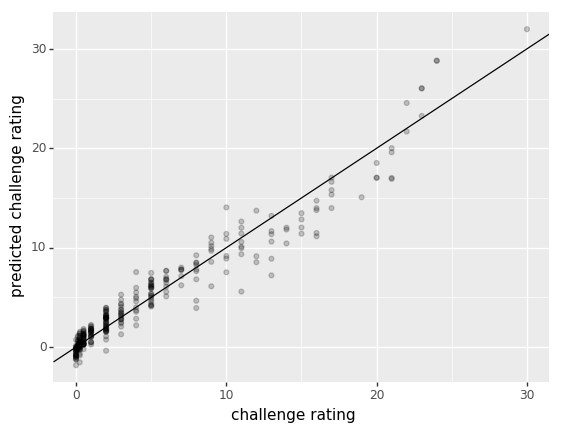

<ggplot: (281772029)>

In [25]:
pred = pd.DataFrame({'challenge rating': y,
                     'predicted challenge rating': lr.predict(X)})
ggplot(pred, aes(x='challenge rating', y='predicted challenge rating')) \
    + geom_point(alpha=0.2) + geom_abline(intercept = 0, slope = 1)

In [26]:
pred['delta'] = pred['challenge rating'] - pred['predicted challenge rating']
pred.describe()

,challenge rating,predicted challenge rating,delta
count,325.000000,325.000000,3.250000e+02
mean,4.575000,4.575000,-2.076971e-16
std,5.916626,5.743053,1.422603e+00
min,0.000000,-1.828077,-4.810219e+00
25%,0.500000,0.540429,-8.598994e-01
50%,2.000000,2.489834,-7.532273e-02
75%,6.000000,6.789108,4.796605e-01
max,30.000000,31.977478,5.787926e+00


In [27]:
std_dev = pred.delta.std()
mean = pred.delta.mean()
mask = (pred.delta > mean + 1.7 * std_dev) | (pred.delta < mean - 1.7 * std_dev)
pred[mask].sort_values('delta', ascending=False)

,challenge rating,predicted challenge rating,delta
name,,,
Rakshasa,13.0,7.212074,5.787926
Chain Devil,11.0,5.577169,5.422831
Iron Golem,16.0,11.144333,4.855667
Marilith,16.0,11.474091,4.525909
Vampire,13.0,8.886017,4.113983
Lich,21.0,16.918856,4.081144
Cloaker,8.0,3.925039,4.074961
Solar,21.0,17.013282,3.986718
Balor,19.0,15.071598,3.928402


# Logistic classification

In [28]:
X = pd.read_pickle('data/bow_X')
y = pd.read_pickle('data/bow_y')

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression()),
])

pipeline.fit(X, y);

In [30]:
pred = pd.DataFrame(pipeline.predict_proba(X), columns=pipeline.classes_)
pred['level'] = y
pred['level_hat'] = pipeline.predict(X)

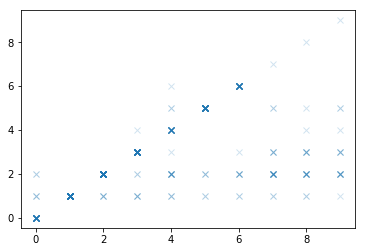

In [31]:
plt.plot(pred['level'], pred['level_hat'], 'x', alpha=0.2)
plt.show()

# Playing with neural networks

In [32]:
from keras.models import Sequential
from keras.layers.core import Activation, Dense
from keras.optimizers import SGD

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [33]:
# reload data
X = pd.read_pickle('data/simple_X')
y = pd.read_pickle('data/simple_y')
shape = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y)

scale_x = StandardScaler()
scale_y = StandardScaler()
# pre-process
sX = scale_x.fit_transform(X_train)
sy = scale_y.fit_transform(y_train)
sX_test = scale_x.transform(X_test)
sy_test = scale_y.transform(y_test)

# specify model
model = Sequential()
model.add(Dense(32, input_shape=(shape,)))
model.add(Activation('relu'))
model.add(Dense(32, input_shape=(shape,)))
model.add(Activation('relu'))
model.add(Dense(32, input_shape=(shape,)))
model.add(Activation('relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer=SGD(), metrics=['mae']) # mae - mean absolute error

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_3 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total para

In [35]:
network_history = model.fit(sX, sy, epochs=30, verbose=0, validation_data=(sX_test, sy_test))

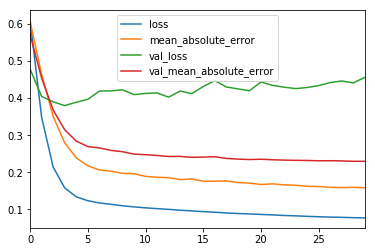

In [36]:
pd.DataFrame(network_history.history).plot()

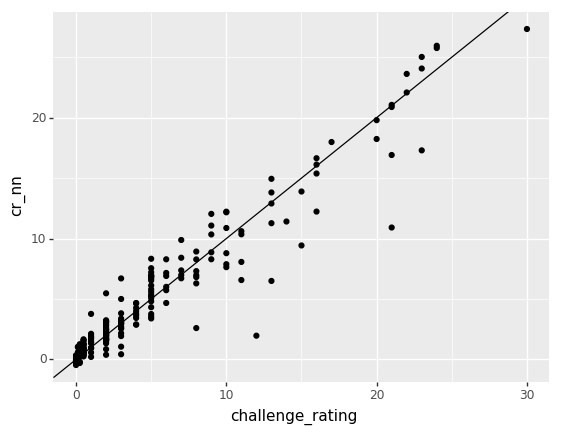

<ggplot: (293224263)>

In [37]:
y_hat = scale_y.inverse_transform(model.predict(sX))
pred = y_train.copy()
pred['cr_nn'] = y_hat

ggplot(pred, aes(x='challenge_rating', y='cr_nn')) + geom_point() + geom_abline(intercept = 0, slope = 1)

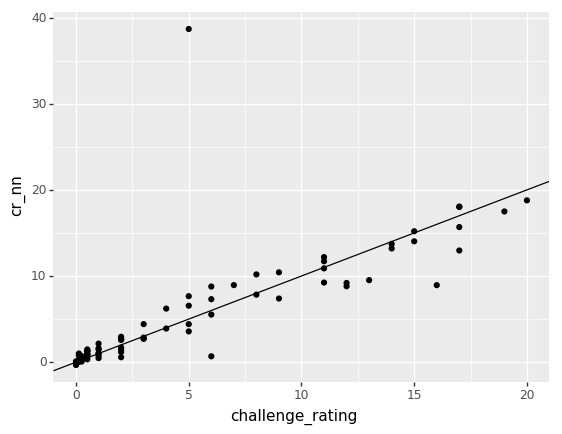

<ggplot: (293268807)>

In [38]:
pred = y_test.copy()
sX_test = scale_x.transform(X_test)
y_hat = scale_y.inverse_transform(model.predict(sX_test))
pred['cr_nn'] = y_hat

ggplot(pred, aes(x='challenge_rating', y='cr_nn')) + geom_point() + geom_abline(intercept = 0, slope = 1)

# Deep Dreaming

In [39]:
from keras import backend as K

In [40]:
K.set_learning_phase(0) # 0 = test, 1 = train
layer_dict = {layer.name: layer for layer in model.layers}

dream = model.input
TARGET = scale_y.transform(5)

# build new loss function
target = K.constant(TARGET, dtype='float32')
loss = K.variable(0, dtype='float32')
coeff = 1.
x = layer_dict['dense_4'].output - target
scaling = K.prod(K.cast(K.shape(x), 'float32'))
loss = coeff * K.sum(K.square(x)) / scaling

# Compute the gradients of loss wrt the dream, and normalize.
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value of the loss and gradients given an input.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    return fetch_loss_and_grads([x])

def gradient_descent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            raise Exception('Loss value {} is larger then the max_loss'.format(loss_value))
        x -= step * grad_values
        yield x, loss_value
    return

In [41]:
# example

x = X.loc['Kobold'].values.reshape(1, -1)
sx = scale_x.transform(x)

step = 0.01  # Gradient ascent step size
iterations = 30  # Number of ascent steps per scale
max_loss = 10.

history = gradient_descent(sx, iterations, step, max_loss)

/Users/jason/Code/cr/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [42]:
x_vals = list()
y_vals = list()
losses = list()

for x, loss in history:
    x_vals.append(scale_x.inverse_transform(x)[0])
    y = scale_y.inverse_transform(model.predict(x))[0][0]
    y_vals.append(y)
    losses.append(loss)
    
output = pd.DataFrame([range(len(y_vals)), y_vals]).transpose()

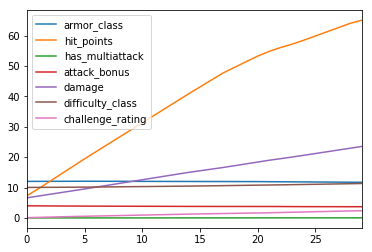

In [43]:
x_vals_df = pd.DataFrame(x_vals)
x_vals_df.columns = X.columns
x_vals_df['challenge_rating'] = y_vals
x_vals_df.plot();

# future work
* better hierarchical models
* try using generative adversarial networks (GANs), due to embedding properties?
* how does `size` correspond to language used in `actions`?
* different use cases should be considered -> generating semi-structured text
* from other representations (power ratings, prose), generate stat blocks with target levels.